================================================================================
## Exploratory Data Analysis for the Air Quality Dataset - Part 3
### Selecting And Comparing Air Quality of Top Tier Seven Cities 
================================================================================


### What Is The Most Relevant Way To Visualize The Difference of Air Quality Between Selected Cities?
#### Methodology
1. Select Top 7 cities accordingly to the counts of measured AQI (For the purpose of extracting the most relevant data)
2. Summarize and compare cities accordingly to the height of their mean AQI value and to the counts of measured AQI value
3. Create a scatterplot displaying the relationship between the mean AQI value and mean indicator value for each top tier city
4. Create a series of pie plots, line charts and tables summarizing basic trends of the rate of Air Pollution for each top tier city
5. Compare the analysis of  mean concentration of PM10 and P02.5 in top tier cities 
6. Display, how many times the AQI value is higher than the norm threshold for each city in the top tier cities

================================================================================
#### Import Necessary Libraries, Functions and Datasets From The Previous Methodology Steps

In [ ]:
#Previous Steps Summarized
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.dates as mdates

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats

#-----------------------------------------------------------------------------------------------------------------------------------------------

df_station_hour = pd.read_csv(r'C:\Users\Lenovo\.cache\kagglehub\datasets\rohanrao\air-quality-data-in-india\versions\12\station_hour.csv')
df_stations = pd.read_csv(r'C:\Users\Lenovo\.cache\kagglehub\datasets\rohanrao\air-quality-data-in-india\versions\12\stations.csv')

#-----------------------------------------------------------------------------------------------------------------------------------------------

df_station_hour = df_station_hour[df_station_hour['Datetime'].isna() == False]
df_cities = pd.merge(df_station_hour, df_stations, how = 'left', on = 'StationId')
df_cities = df_cities[df_cities['Status'] == 'Active']
df_cities['Datetime'] = pd.to_datetime(df_cities['Datetime'])

#-----------------------------------------------------------------------------------------------------------------------------------------------

def remove_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR 
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

#-----------------------------------------------------------------------------------------------------------------------------------------------

df_city = df_cities.copy()
df_city.loc[:, 'PM2.5' : 'AQI'] = remove_outliers(df_city.loc[:, 'PM2.5' : 'AQI'])

#-----------------------------------------------------------------------------------------------------------------------------------------------

data = df_city.loc[:, 'PM2.5' : 'AQI'].copy()
correlation_matrix = data.corr(method='spearman')

#-----------------------------------------------------------------------------------------------------------------------------------------------

df_city['Date_Day'] = df_city['Datetime'].dt.to_period('D')

datetime_index = df_city.columns.get_loc('Datetime')
df_city.insert(datetime_index + 1, 'Date_Day', df_city.pop('Date_Day'))

df_city['Date_Day'] = df_city['Date_Day'].astype('str')


df_city['Date_Month'] = df_city['Datetime'].dt.to_period('M')

datetime_index = df_city.columns.get_loc('Datetime')
df_city.insert(datetime_index + 1, 'Date_Month', df_city.pop('Date_Month'))

df_city['Date_Month'] = df_city['Date_Month'].astype('str')
df_city['Date_Month'] = pd.to_datetime(df_city['Date_Month'])

#-----------------------------------------------------------------------------------------------------------------------------------------------

def d_create_pivot(df_list):
    values = df_cities.loc[0:0, 'PM2.5':'AQI'].columns.to_list()
    bins = [5,50,100,200,300,400,5000]
    labels = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']

    bins2 = [5,100,5000]
    labels2 = ['Satisfactory','Unsatisfactory']

    pivot_list = []
    for i in range(len(df_list)):
        df_pivot = df_list[i].pivot_table(values = values, index='Date_Day', aggfunc='mean')
        df_pivot['AQI_Bucket'] = pd.cut(df_pivot['AQI'], bins=bins, labels=labels, right=False)
        df_pivot['Satisfactory_AQI'] = pd.cut(df_pivot['AQI'], bins=bins2, labels=labels2, right=False)
        df_pivot = df_pivot.reset_index()
        df_pivot.insert(1, 'AQI_Bucket', df_pivot.pop('AQI_Bucket'))
        df_pivot.insert(2, 'Satisfactory_AQI', df_pivot.pop('Satisfactory_AQI'))
        df_pivot.loc[:, 'AQI':] = df_pivot.loc[:, 'AQI':].fillna(0)
        pivot_list.append(df_pivot)

    return pivot_list

def m_create_pivot(df_list):
    values = df_cities.loc[0:0, 'PM2.5':'AQI'].columns.to_list()
    bins = [5,50,100,200,300,400,5000]
    labels = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']

    bins2 = [5,100,5000]
    labels2 = ['Satisfactory','Unsatisfactory']

    pivot_list = []
    for i in range(len(df_list)):
        df_pivot = df_list[i].pivot_table(values = values, index='Date_Month', aggfunc='mean')
        df_pivot['AQI_Bucket'] = pd.cut(df_pivot['AQI'], bins=bins, labels=labels, right=False)
        df_pivot['Satisfactory_AQI'] = pd.cut(df_pivot['AQI'], bins=bins2, labels=labels2, right=False)
        df_pivot = df_pivot.reset_index()
        df_pivot.insert(1, 'AQI_Bucket', df_pivot.pop('AQI_Bucket'))
        df_pivot.insert(2, 'Satisfactory_AQI', df_pivot.pop('Satisfactory_AQI'))
        df_pivot.loc[:, 'AQI':] = df_pivot.loc[:, 'AQI':].fillna(0)
        pivot_list.append(df_pivot)

    return pivot_list

#-----------------------------------------------------------------------------------------------------------------------------------------------

def all_indexes(pivot_list):
    aqi_correlations = correlation_matrix['AQI']
    correlations_aqi = list(float (x) for x in aqi_correlations.values[:-1])
    params_aqi = list(aqi_correlations.index[:-1])
    for i in range(len(pivot_list)):
        pivot_list[i]['Weighted Sum Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)

    correlations_aqi = list(float (x) for x in aqi_correlations.values[:2])
    params_aqi = list(aqi_correlations.index[:2])
    for i in range(len(pivot_list)):
        pivot_list[i]['Particulate Matter Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)

    correlations_aqi = list(float (x) for x in aqi_correlations.values[2:6])
    params_aqi = list(aqi_correlations.index[2:6])
    for i in range(len(pivot_list)):
        pivot_list[i]['Nitrogen Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)
    
    correlations_aqi = list(float (x) for x in aqi_correlations.values[6:9])
    params_aqi = list(aqi_correlations.index[6:9])
    for i in range(len(pivot_list)):
        pivot_list[i]['Oxydative Gases Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)

    correlations_aqi = list(float (x) for x in aqi_correlations.values[9:-1])
    params_aqi = list(aqi_correlations.index[9:-1])
    for i in range(len(pivot_list)):
        pivot_list[i]['Volatile Organic Compounds (BTX) Index'] = pivot_list[i].apply(lambda x: sum(x[col]*correlations_aqi[c] for c, col in enumerate(params_aqi) if col in pivot_list[i].columns.to_list()), axis=1)
    return pivot_list

listed_object = []
listed_object.append(df_city)
l_month = m_create_pivot(listed_object)
l_day = d_create_pivot(listed_object)
l_month = all_indexes(l_month)
l_day = all_indexes(l_day)
m_c_pivot = l_month[0]
d_c_pivot = l_day[0]


### Select the Top 7 Cities in the Dataframe and use a Proper Delection Tool to Filter out Those Cities in the Dataframe

In [ ]:
# Remove empty values from the dataset accordingly to the selected column
df_city = df_city[df_city['PM2.5'].isna()==False]

# Selecting top 7 cities with the highest count of AQI measurements
top_7_cities = df_city.groupby('City').size().reset_index().rename(columns={0:'Counts'}, inplace = False).sort_values(by='Counts', ascending=False).head(7)

# Creating a list of Selected 7 Top Tier Cities (Sorted in the Order of the Highest Mean AQI Measurements)
cities = ['Delhi', 'Visakhapatnam', 'Amaravati', 'Hyderabad', 'Amritsar', 'Chandigarh', 'Kolkata']

# Creating a column dividing 7 Top Tier Cities from Other Cities
df_city['top_7'] = df_city['City'].apply(lambda x: x if x in cities else 'other cities')

# Creating a Pivot Table to Display the Count of AQI Measurements for Each Top Tier City and Other Cities
top_cities = df_city.groupby('top_7').size().reset_index().rename(columns={0:'Counts'}, inplace = False).sort_values(by='Counts', ascending=False)

### Create a Pie Plot Showing the Percentage of AQI Measurements for Each Top Tier City

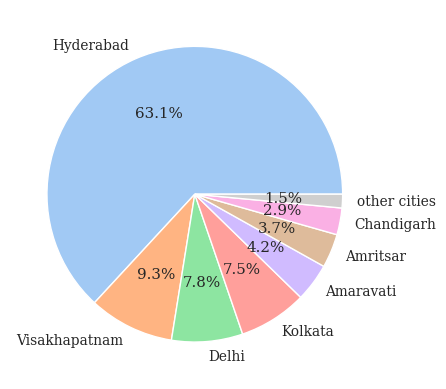

<Figure size 2400x2400 with 0 Axes>

In [31]:
# Top tier 7 cities  pie plot visualization
sns.set_theme(palette='pastel', font='serif', font_scale=0.9)


plt.pie(top_cities['Counts'].tolist(), labels=top_cities['top_7'].tolist(), autopct='%1.1f%%')

plt.figure(figsize=(24,24))
plt.show()

### Create a Function to Split Dataframe into List of Dataframes Accordingly To The Selected City

In [32]:
def filter_cities(df, cities):
    df_list = []
    for city in cities:
        df_city = df[df['City']==city].copy()
        values = df.loc[0:0, 'PM2.5':'AQI'].columns.to_list()
        values = values[:-1]
        
        if df_city['PM2.5'].notna().any():
            df_list.append(df_city)

    return df_list

### Create Pivot Lists of City Dataframes in Order to Monitor Mean Concentration Values of Contaminants and Mean Index Values By Each City
1. Creating a pivot table to display values on monthly basis
2. Creating a pivot table to display values on daily basis

In [33]:
df = df_city.copy()
df_list = filter_cities(df, cities)

m_list = m_create_pivot(df_list)
d_list = d_create_pivot(df_list)

monthly_p = all_indexes(m_list)
daily_p = all_indexes(d_list)
daily_p.append(d_c_pivot)


### Create Pivot Tables That Summarize Mean Parameters of Selected Indexes and Selected Pollutant Concentrations by Two Types of Air Quality Indicator Categories

In [34]:

pivot_list = daily_p.copy()
d_stat_pivot = []
for i in range(len(pivot_list)):
    pivot_list[i] = pivot_list[i][pivot_list[i]['Weighted Sum Index']!=0]
    stat_pivot = pivot_list[i].pivot_table(values = ['AQI', 'Weighted Sum Index','Particulate Matter Index', 'Nitrogen Index', 'Oxydative Gases Index', 'Volatile Organic Compounds (BTX) Index','PM10', 'PM2.5', 'CO', 'NO2', 'NH3'], index = 'AQI_Bucket', aggfunc=['min', 'max', 'mean', 'median','count'], observed=True)
    stat_pivot = stat_pivot.reset_index()
    pivot = pd.DataFrame()
    pivot['AQI_Bucket'] = stat_pivot['AQI_Bucket']
    pivot['AQI_min'] = stat_pivot['min']['AQI']
    pivot['AQI_max'] = stat_pivot['max']['AQI']
    pivot['AQI'] = stat_pivot['mean']['AQI']
    pivot['WS'] = stat_pivot['mean']['Weighted Sum Index']
    pivot['PM'] = stat_pivot['mean']['Particulate Matter Index']
    pivot['N'] = stat_pivot['mean']['Nitrogen Index']
    pivot['OX'] = stat_pivot['mean']['Oxydative Gases Index']
    pivot['BTX'] = stat_pivot['mean']['Volatile Organic Compounds (BTX) Index']
    pivot['PM10_mean'] = stat_pivot['mean']['PM10']
    pivot['PM2.5_mean'] = stat_pivot['mean']['PM2.5']
    pivot['CO_mean'] = stat_pivot['mean']['CO']
    pivot['NO2_mean'] = stat_pivot['mean']['NO2']
    pivot['NH3_mean'] = stat_pivot['mean']['NH3']
    pivot['Count'] = stat_pivot['count']['Weighted Sum Index']
    d_stat_pivot.append(pivot)

table_p = daily_p.copy()
dd_stat_pivot = []
for i in range(len(table_p)):
    stat = table_p[i].pivot_table(values = ['AQI', 'Weighted Sum Index','Particulate Matter Index', 'Nitrogen Index', 'Oxydative Gases Index', 'Volatile Organic Compounds (BTX) Index','PM10', 'PM2.5', 'CO', 'NO2', 'NH3'], index = 'Satisfactory_AQI', aggfunc=['min', 'max', 'mean', 'median','count'], observed=False)
    stat = stat.reset_index()
    pivot = pd.DataFrame()
    pivot['Satisfactory_AQI'] = stat['Satisfactory_AQI']
    pivot['AQI'] = stat['mean']['AQI']
    pivot['WS'] = stat['mean']['Weighted Sum Index']
    pivot['PM'] = stat['mean']['Particulate Matter Index']
    pivot['N'] = stat['mean']['Nitrogen Index']
    pivot['OX'] = stat['mean']['Oxydative Gases Index']
    pivot['BTX'] = stat['mean']['Volatile Organic Compounds (BTX) Index']
    pivot['PM10_mean'] = stat['mean']['PM10']
    pivot['PM2.5_mean'] = stat['mean']['PM2.5']
    pivot['CO_mean'] = stat['mean']['CO']
    pivot['NO2_mean'] = stat['mean']['NO2']
    pivot['NH3_mean'] = stat['mean']['NH3']
    pivot['Count'] = stat['count']['Weighted Sum Index']
    dd_stat_pivot.append(pivot)



### Create a Dataset Containing Callculated Indexes for each City and Selects Top Tier 7 Cities in a Particular Column

In [ ]:
# create a dataset that include all the cities and calculated indexes
list_city =  []
list_city.append(df_city)

city_indexed = all_indexes(list_city)
df_c = city_indexed[0].fillna(0)

# city mean Air Quality Index values dataframe
df_c = df_c[df_c['top_7'] != 'other cities']
df_city_p = df_c.pivot_table(values=['Weighted Sum Index','Particulate Matter Index','PM2.5', 'PM10', 'Nitrogen Index', 'Oxydative Gases Index', 'Volatile Organic Compounds (BTX) Index','AQI'], index='top_7', aggfunc = 'mean')
df_city_p = df_city_p.reset_index()

# city  Day counts DataFrame
cities = list(df_c['top_7'].unique())
day_counts = [len(df_c[df_c['top_7'] == city ]['Date_Day'].unique()) for city in cities]

city_days = pd.DataFrame()
city_days['Cities'] = cities
city_days['Day_Counts'] = day_counts
city_days = city_days.sort_values(by='Day_Counts')


### Create a Bar Chart Displaying The Sorted Top Tier Cities Based on the Height of Their Mean AQI Value 

Text(0.5, 1.0, 'Mean AQI Values in Top 7 Cities')

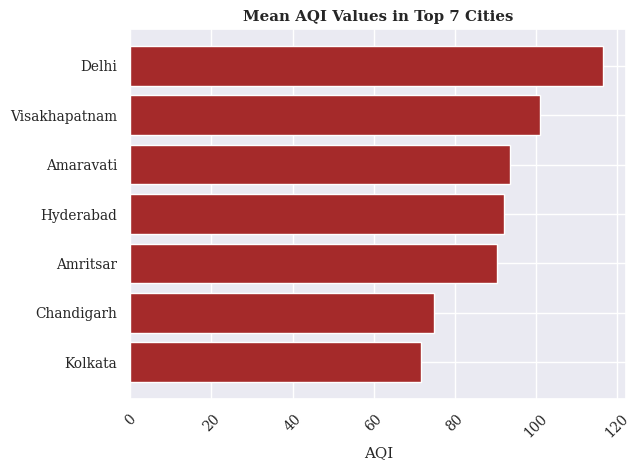

In [36]:
# bar plot mean AQI measures by Cities
sorted_df_city_p = df_city_p.sort_values(by='AQI').copy()
plt.barh(sorted_df_city_p['top_7'], sorted_df_city_p['AQI'], color = 'brown')
plt.xticks(rotation=45)

plt.xlabel('AQI')
plt.title('Mean AQI Values in Top 7 Cities', weight='bold')

### Create a Bar Chart Showing The Sorted Top Tier Cities Based on the Number of Measured AQI Values in the Dataset

Text(0.5, 1.0, 'Count of Days of AQI Measurement in Top 7 Cities')

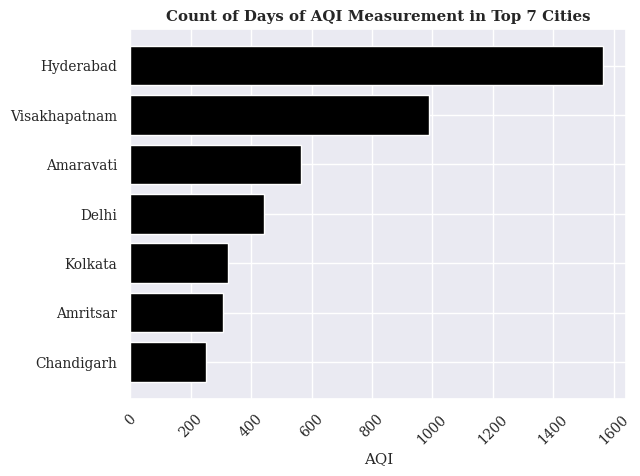

In [37]:
#barplot Day counts by Cities

plt.barh(city_days['Cities'], city_days['Day_Counts'], color = 'black')
plt.xticks(rotation=45)

plt.xlabel('AQI')
plt.title('Count of Days of AQI Measurement in Top 7 Cities', weight='bold')

### Create Scatterplots that Display The Relationship Between  Air Quality Index and Calculated Indexes across Top Tier Cities
1. Create Scatterplots to Display the Linear correlation of Air Quality Index and Calculated Index for Each Top Tier City
2. Calculate Pearson Correlation Coeffeicient, p-value and R-squared value to identify the strengh of linear relationship between the AQI value and Calculated Index value
3. Display the results on a table format next to the scatterplot

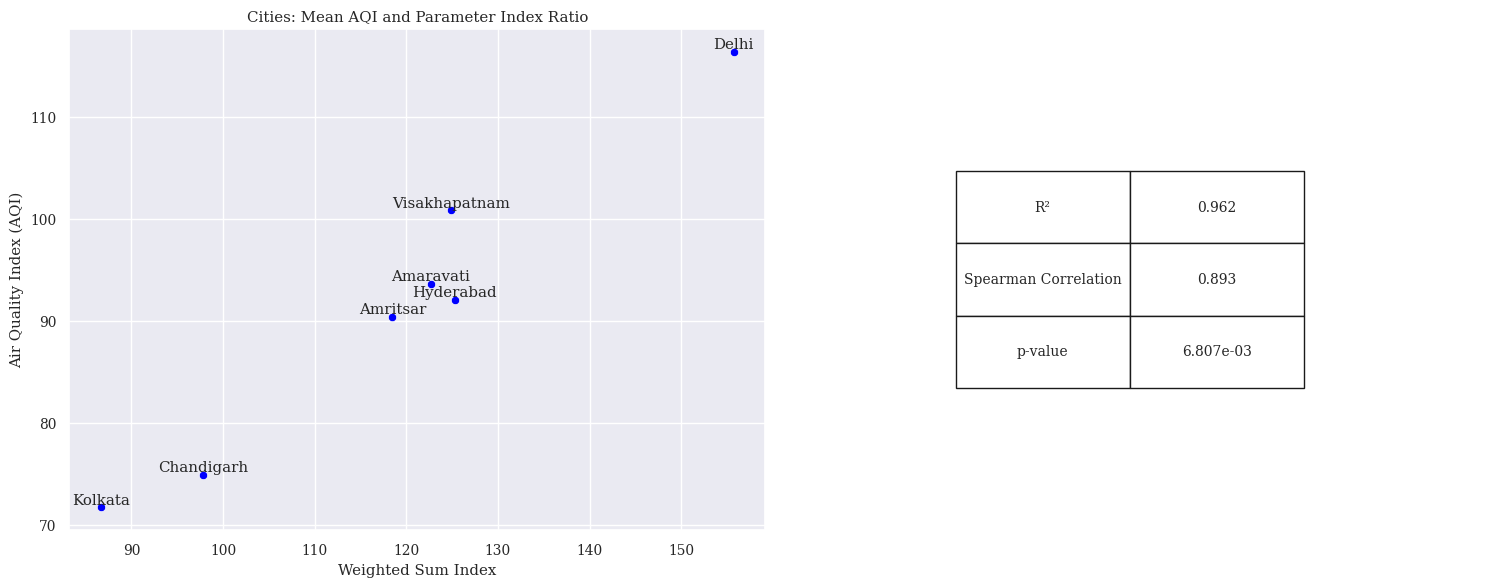

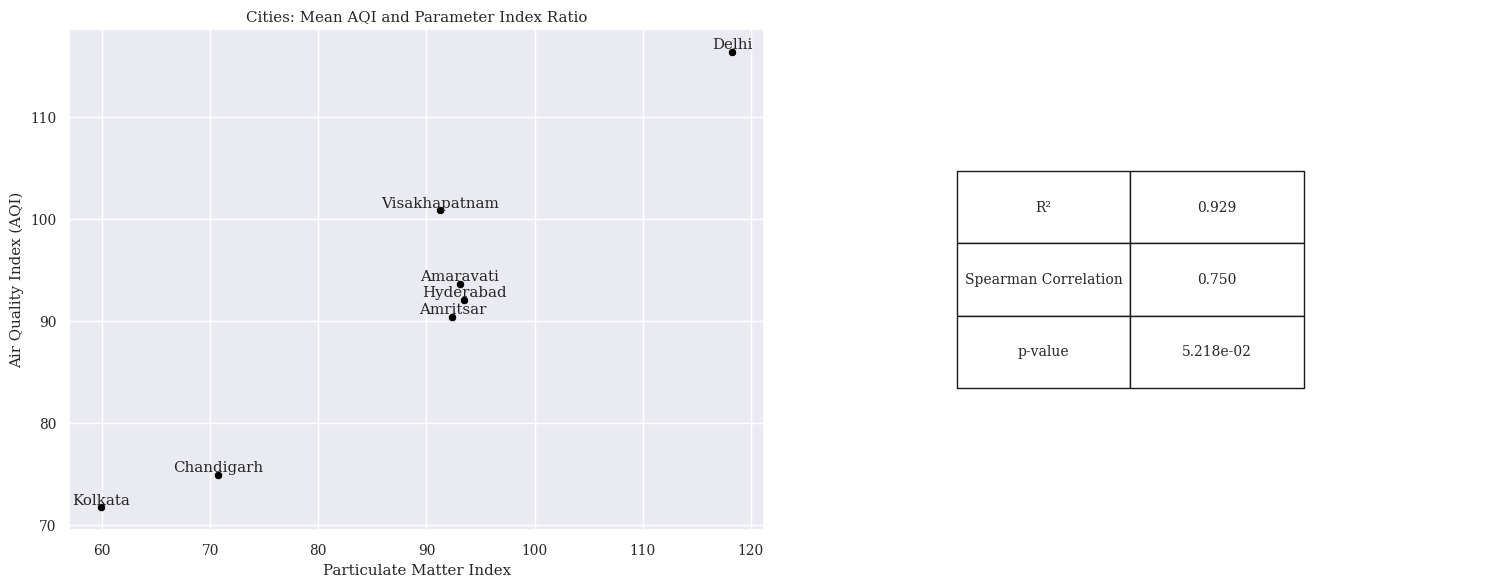

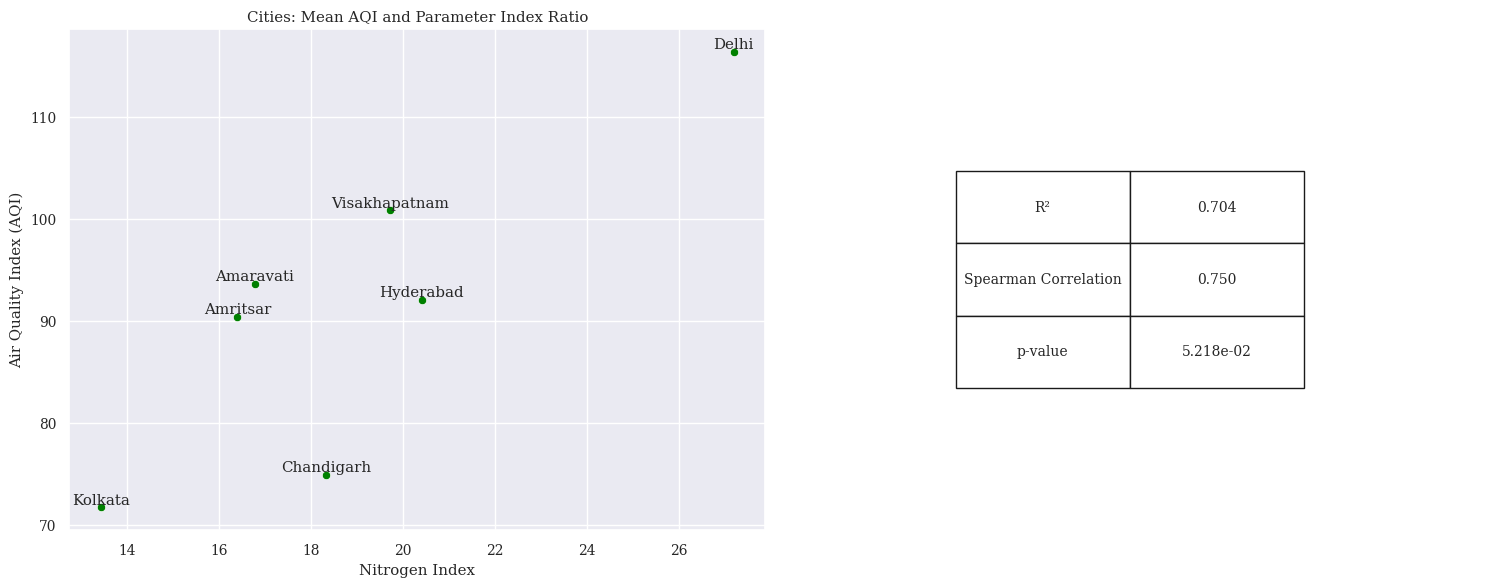

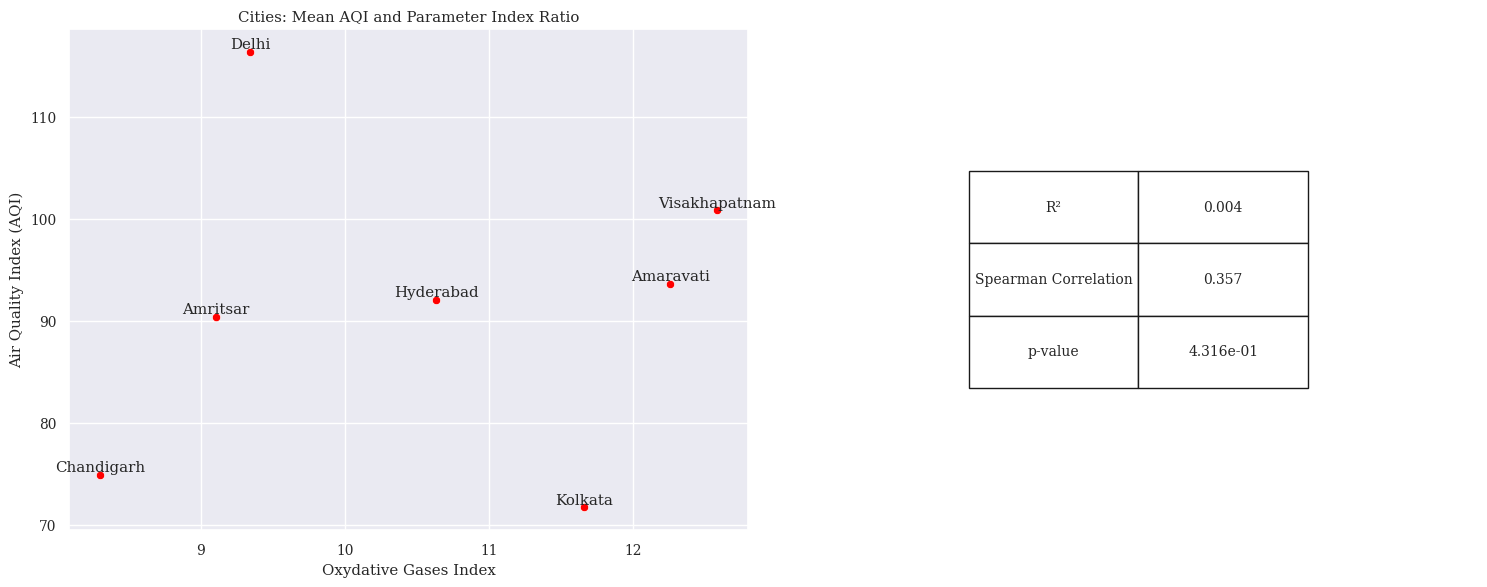

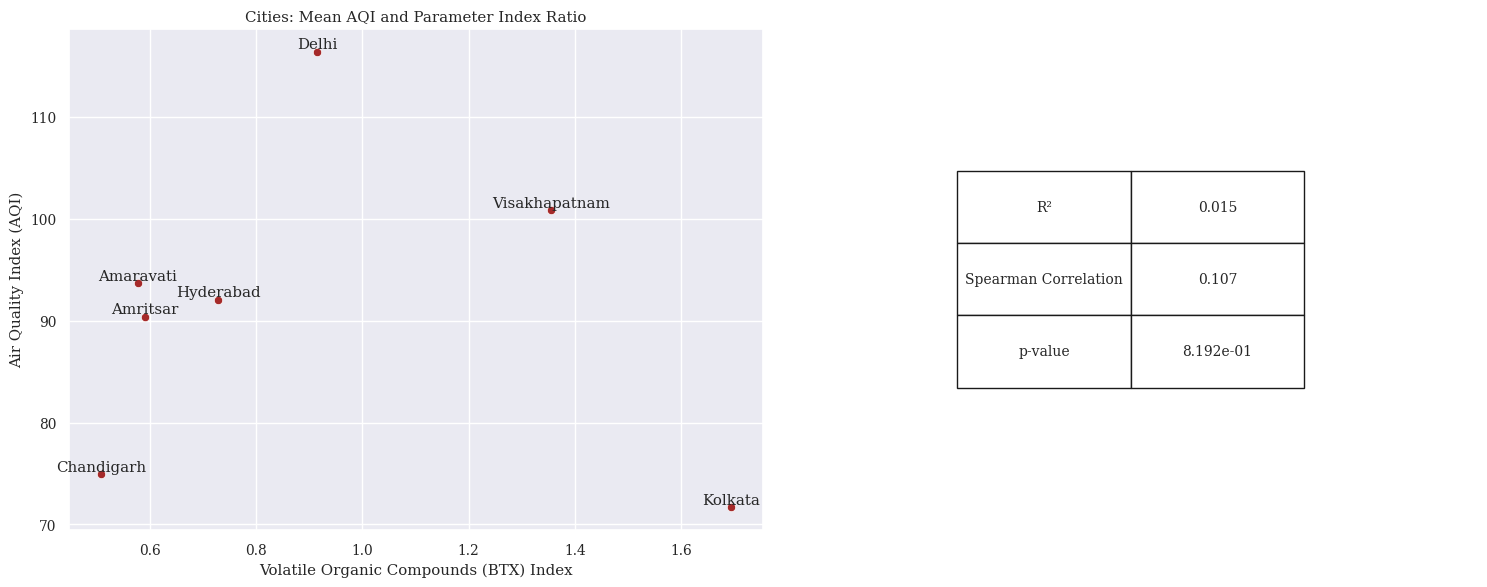

In [38]:
#City Scatterplots

indexes = df_c.loc[0:0,'Weighted Sum Index':'Volatile Organic Compounds (BTX) Index'].columns.to_list()

colors = ['blue', 'black', 'green', 'red', 'brown']

for a  in range(len(indexes)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6))
    sns.scatterplot(data = df_city_p, x=indexes[a], y = 'AQI', color=colors[a], ax = ax1)

    for i in range(len(df_city_p)):
        aqi_mean = df_city_p['AQI'].iloc[i]
        parameter_mean = df_city_p[indexes[a]].iloc[i]
        city_name = df_city_p['top_7'][i]
        ax1.text(parameter_mean, aqi_mean, city_name, ha='center', va='bottom')
    
    ax1.set_title('Cities: Mean AQI and Parameter Index Ratio')
    ax1.set_xlabel(indexes[a])
    ax1.set_ylabel('Air Quality Index (AQI)')
    
    # Calculate Pearson Correlation Coeffcient and p-value
    correlation_coefficient, p_value = stats.spearmanr(df_city_p[indexes[a]], df_city_p['AQI'])

    # Model Linear Regression and Calculate R-squared value
    model = LinearRegression()
    X_reshaped = df_city_p[indexes[a]].values.reshape(-1,1)
    model.fit(X_reshaped, df_city_p['AQI'])
    y_pred = model.predict(X_reshaped)
    r2 = r2_score(df_city_p['AQI'], y_pred)

    metrics_data = [
        ['R²', f'{r2:.3f}'],
        ['Spearman Correlation', f'{correlation_coefficient:.3f}'],
        ['p-value', f'{p_value:.3e}']
    ]

    # Create the table of R-squared , Pearson Correlation and p-value
    table = ax2.table(cellText=metrics_data, loc='center', cellLoc='center')
    ax2.axis('off')
    ax2.axis('off')

    table.auto_set_font_size(False)  # Disable automatic font size
    table.set_fontsize(10)  # Set font size
    table.scale(0.5, 4)  # Scale the table size

    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Display of Air Quality Trends For Each Selected City
1. Create a pie chart to display percentual distribution of days with Satisfactory mean AQI and Unsatisfactory mean AQI
2. Create a line chart to display the trend of mean AQI and mean Particulate Matter Index on monthly bases in the given time period
3. Create a table to display the averages of the AQI, particulate matter concentration, and number of real measurements selected by AQI category

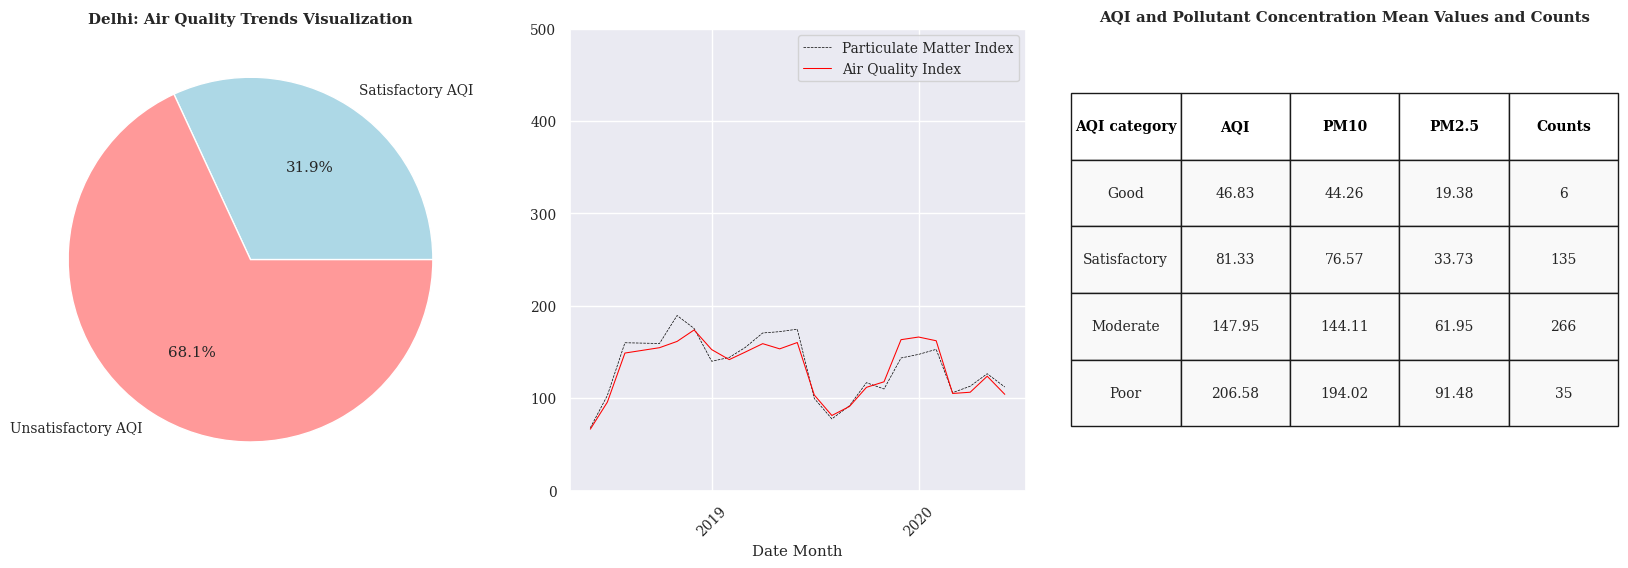

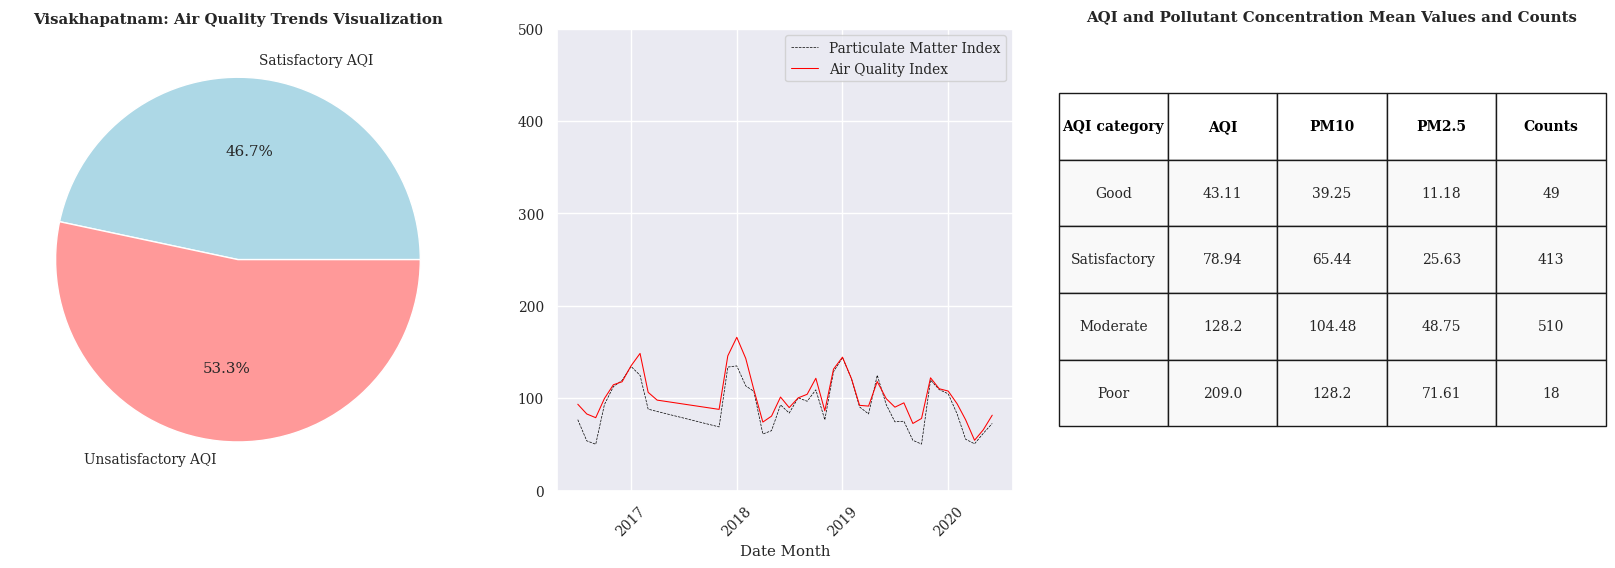

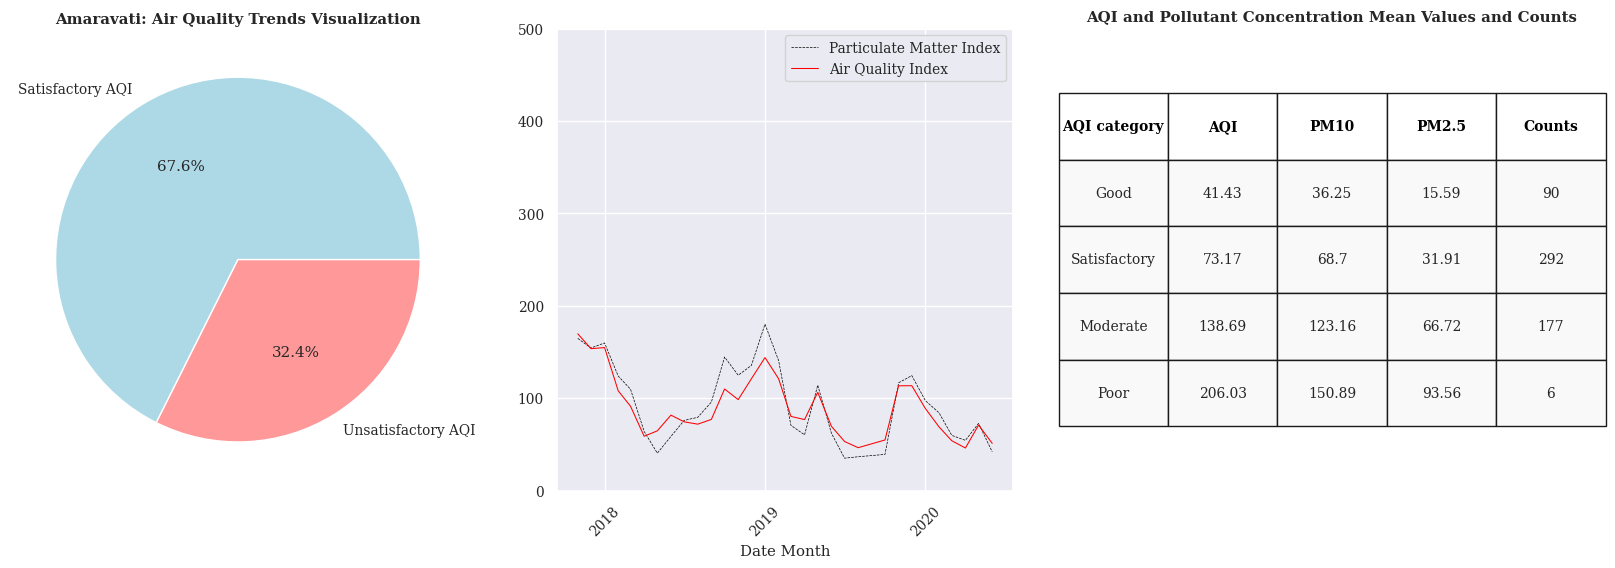

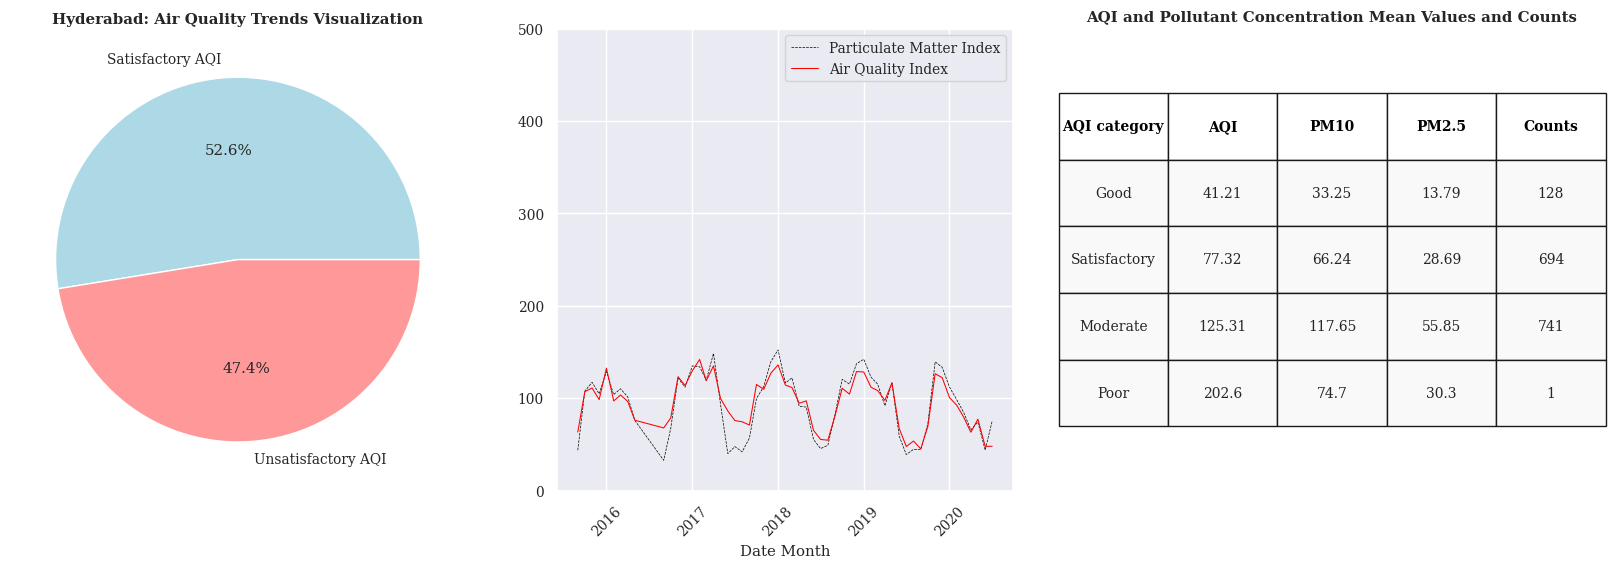

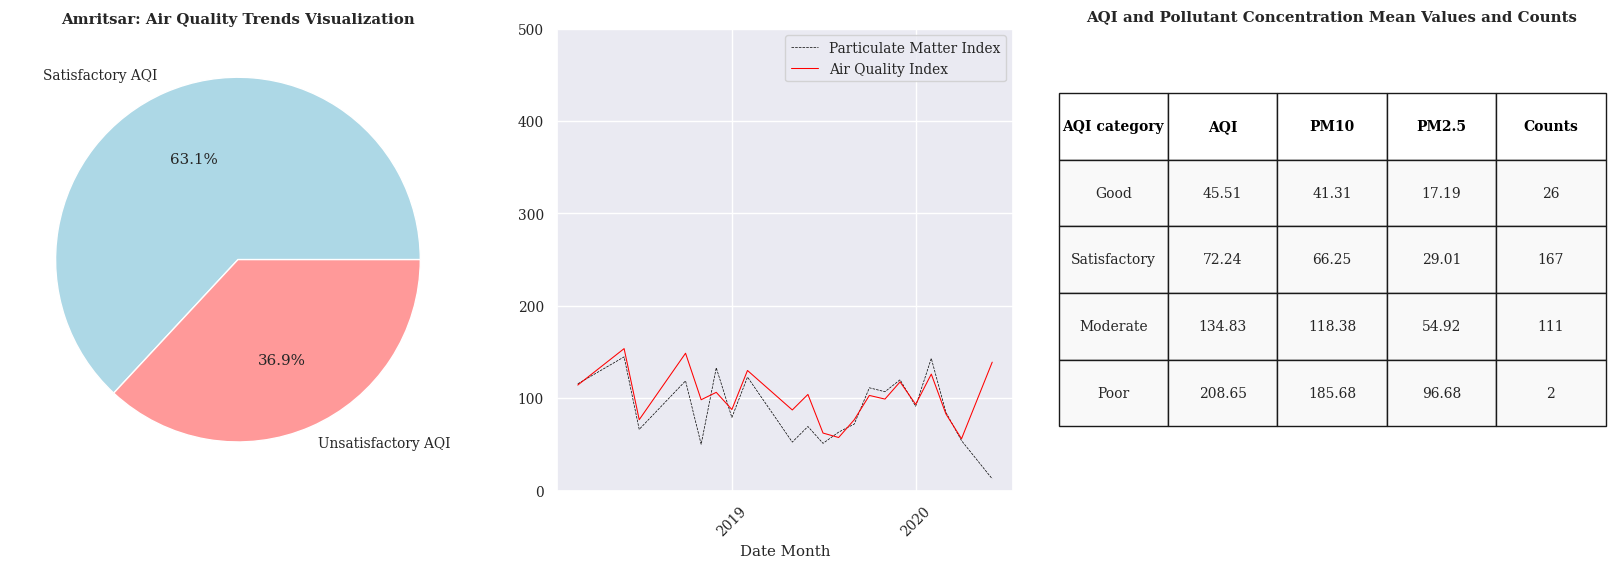

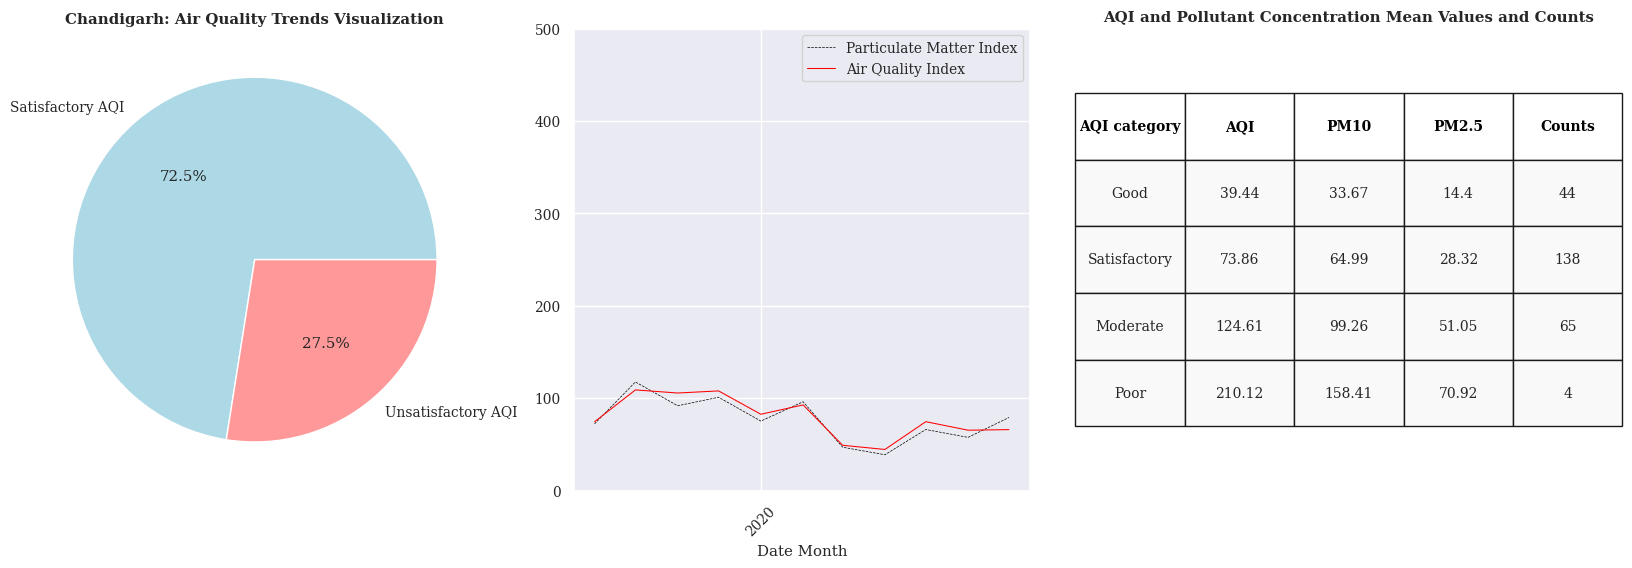

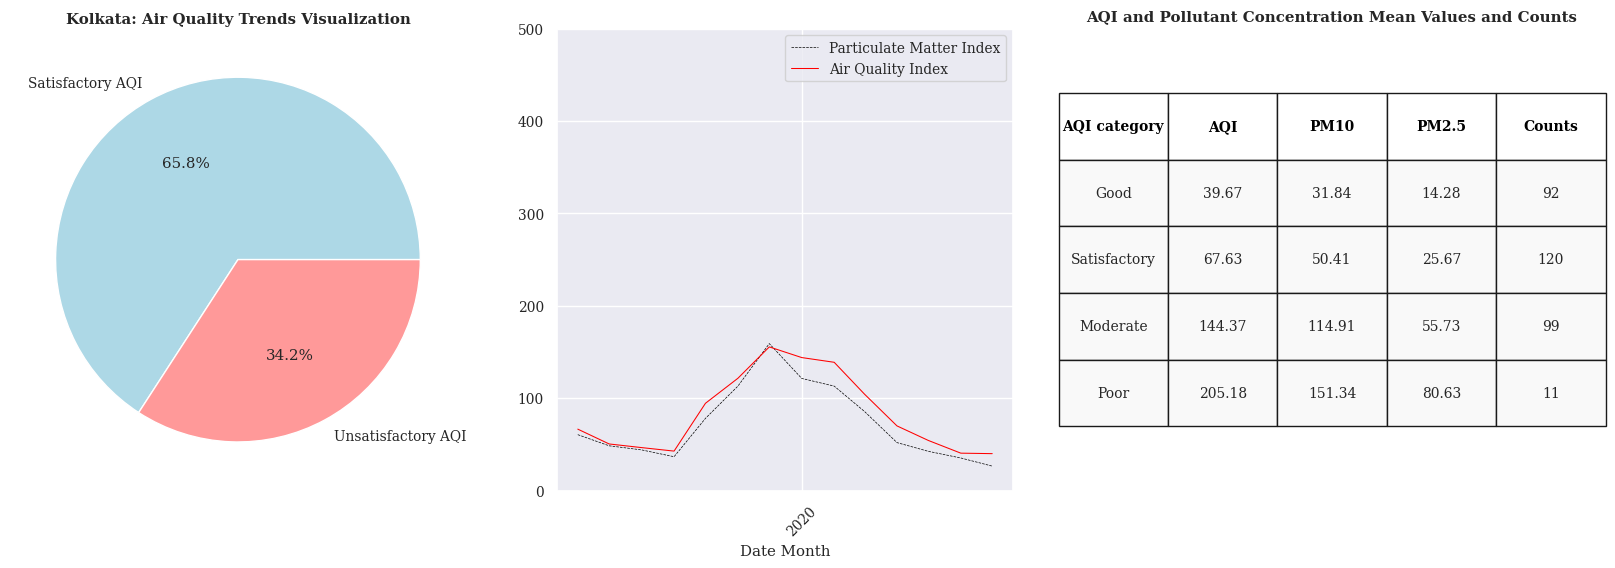

In [ ]:
#City Air Quality Trends Visualization

l_cities = ['Delhi', 'Visakhapatnam', 'Amaravati', 'Hyderabad', 'Amritsar', 'Chandigarh', 'Kolkata']
colors = ['#ADD8E6','#FF9999']

for i in range(7):
    sns.set_theme(palette='pastel', font='serif', font_scale=0.9)
    d_stat_pivot[i].loc[:,'AQI_min':'NH3_mean'] = d_stat_pivot[i].loc[:,'AQI_min':'NH3_mean'].round(2)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,6))

    labels= dd_stat_pivot[i]['Satisfactory_AQI'].tolist()
    changed_labels = ['Satisfactory AQI' if label == 'Satisfactory' else 'Unsatisfactory AQI' for label in labels ]

    ax1.pie(dd_stat_pivot[i]['Count'].tolist(), labels=changed_labels,autopct='%1.1f%%', colors = colors)
    ax1.set_title(f'{l_cities[i]}: Air Quality Trends Visualization', weight='bold')

    ax2.set_ylabel(' ')
    ax2.set_xlabel('Date Month')
    ax2.tick_params(axis = 'x', rotation=45)
    sns.lineplot(x='Date_Month', y='Particulate Matter Index', color = 'black', linestyle='--', linewidth=0.5, data=monthly_p[i], ax=ax2, label = 'Particulate Matter Index')
    sns.lineplot(x='Date_Month', y='AQI',color = 'red', linewidth=0.75, data=monthly_p[i], ax=ax2, label = 'Air Quality Index')
    ax2.xaxis.set_major_locator(mdates.YearLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2.set_ylim(0,500)

    table_data = [d_stat_pivot[i]['AQI_Bucket'],d_stat_pivot[i]['AQI'], d_stat_pivot[i]['PM10_mean'], d_stat_pivot[i]['PM2.5_mean'],d_stat_pivot[i]['Count']]
    table = ax3.table(cellText=np.array(table_data).T, colLabels=['AQI category', 'AQI', 'PM10', 'PM2.5', 'Counts'], loc='center')
    ax3.axis('off')
    ax3.set_title('AQI and Pollutant Concentration Mean Values and Counts', weight='bold')
    table.auto_set_font_size(False)  # Disable automatic font size
    table.set_fontsize(10)  # Set font size
    table.scale(1.2, 4)  # Scale the table size

    # Change the color of the header
    for (a, b), cell in table.get_celld().items():
        if a == 0:  # Header row
            cell.set_text_props(weight='bold', color='black')

        else:
            cell.set_facecolor('#f9f9f9')
            cell.set_text_props(ha='center')


                            
    plt.show()

### Display Bar Graph Showing the Average Concentration of Particulate Matter for Each Top Tier City

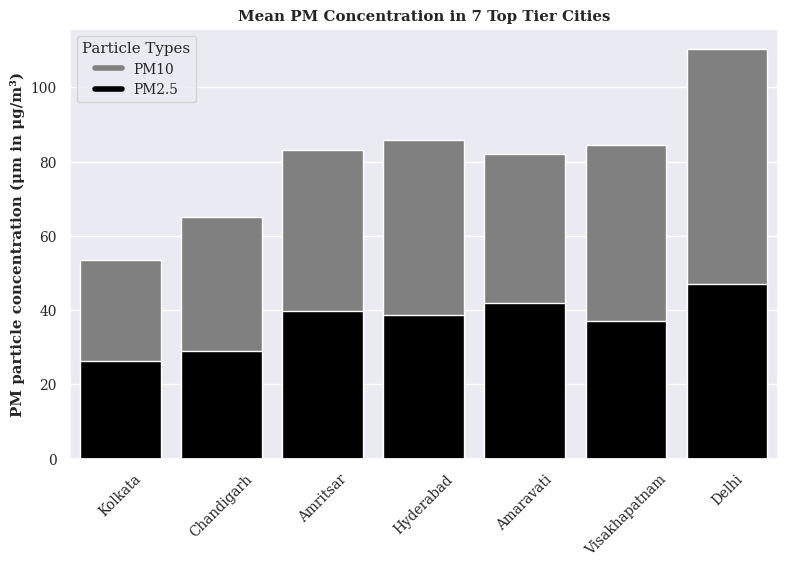

In [40]:
#Bar plot mean PM concentration measures by Top Tier Cities
sorted_df_city_p = df_city_p.sort_values(by='AQI').copy()

fig, ax = plt.subplots(1, figsize=(8,6))

sns.barplot(x = sorted_df_city_p['top_7'], y = sorted_df_city_p['PM10'], color = 'grey', ax = ax, legend = True)
sns.barplot(x = sorted_df_city_p['top_7'], y = sorted_df_city_p['PM2.5'], color = 'black', ax = ax, legend = True)
ax.tick_params( axis = 'x', rotation=45)
ax.set_ylabel('PM particle concentration (μm in μg/m³)', weight='bold')
ax.set_xlabel(' ')
ax.set_title('Mean PM Concentration in 7 Top Tier Cities', weight='bold')


handles = [
    plt.Line2D([0], [0], color='grey', lw=4, label='PM10'),
    plt.Line2D([0], [0], color='black', lw=4, label='PM2.5')
]
ax.legend(handles=handles, title='Particle Types')

plt.tight_layout()
plt.show()


### Create Scatterplot to Display Relationship Between Maximum Measured Values of PM10 and PM2.5 particles for Each Top Tier City based on the Percentage of the Threshold Limit

Text(0, 0.5, 'PM2.5 max value in %')

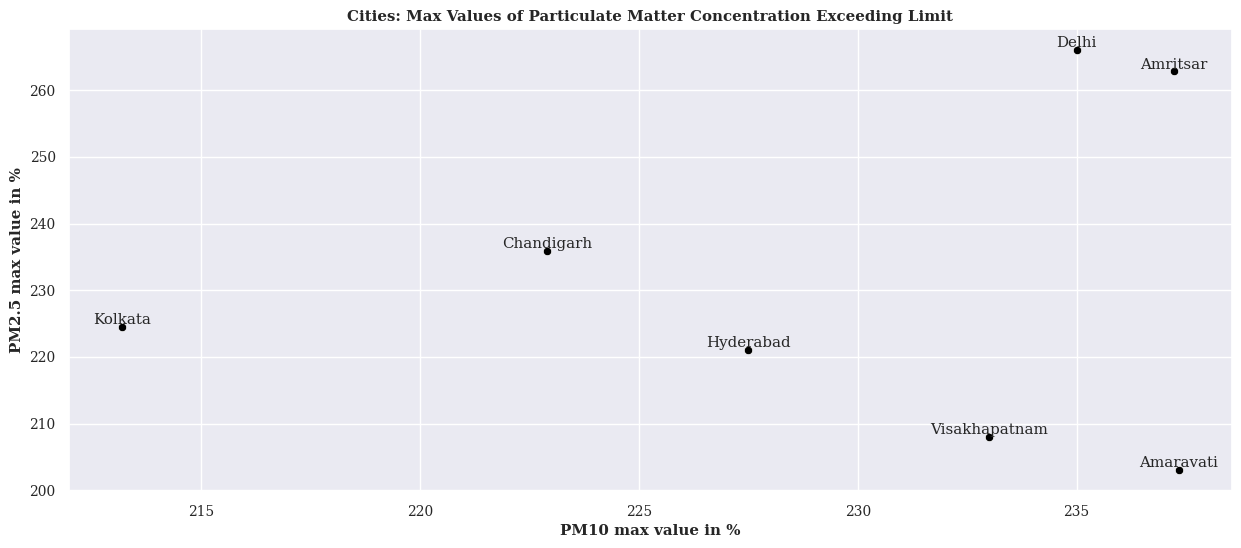

In [41]:
# Create a scatter plot showing the distribution of the maximum values of the PM particle concentration in a metric of the percentage exceeding the threshold (WHO)

norm_values =  ['PM2.5', 'PM10']
norm_limits = [75, 150]

for v in range(len(norm_values)):
        df_c[f'{norm_values[v]} norm %'] = (df_c[norm_values[v]] / norm_limits[v]) * 100
        df_c[f'{norm_values[v]} satisfactory'] = df_c[f'{norm_values[v]} norm %'] <= 100


df_c_p = df_c.pivot_table(values = ['PM2.5 norm %', 'PM10 norm %', 'AQI'], index = 'top_7', aggfunc = 'max').reset_index()
df_c_p = df_c_p[df_c_p['top_7'] != 'other cities']

colors = ['black']

fig, ax1 = plt.subplots(1, figsize=(15,6))
sns.scatterplot(data = df_c_p, x='PM10 norm %', y = 'PM2.5 norm %', color=colors[0], ax = ax1)

for i in range(len(df_c_p)):
    max25 = df_c_p['PM2.5 norm %'].iloc[i]
    max10 = df_c_p['PM10 norm %'].iloc[i]
    city_name = df_c_p['top_7'][i]
    ax1.text(max10, max25, city_name, ha='center', va='bottom')
    
ax1.set_title('Cities: Max Values of Particulate Matter Concentration Exceeding Limit', weight='bold')
ax1.set_xlabel('PM10 max value in %', weight='bold')
ax1.set_ylabel('PM2.5 max value in %', weight='bold')

### Pie Chart Distribution for each Top Tier city Showing the Number of Days With Mean Airborne PM Concentrations Above the Threshold

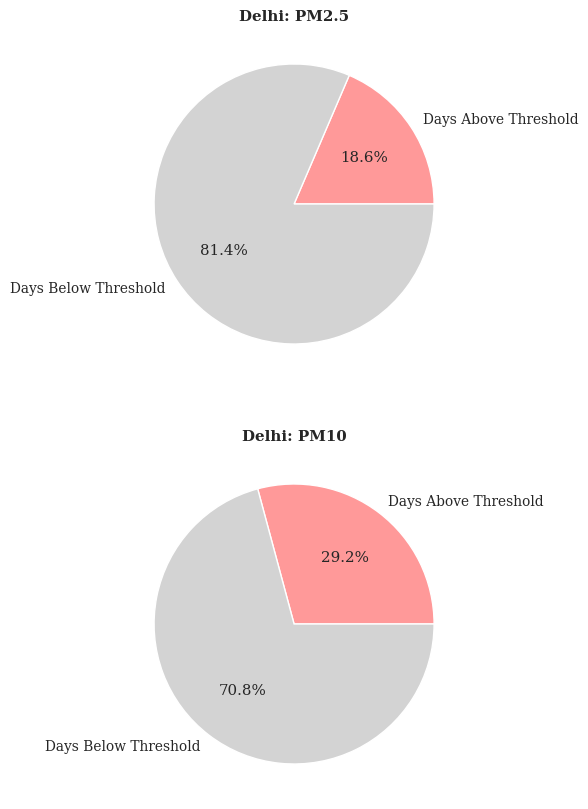

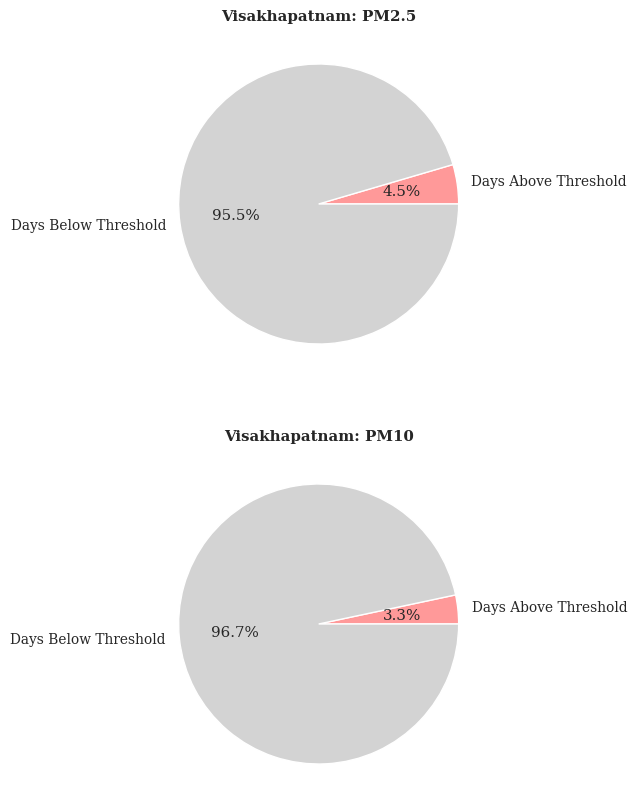

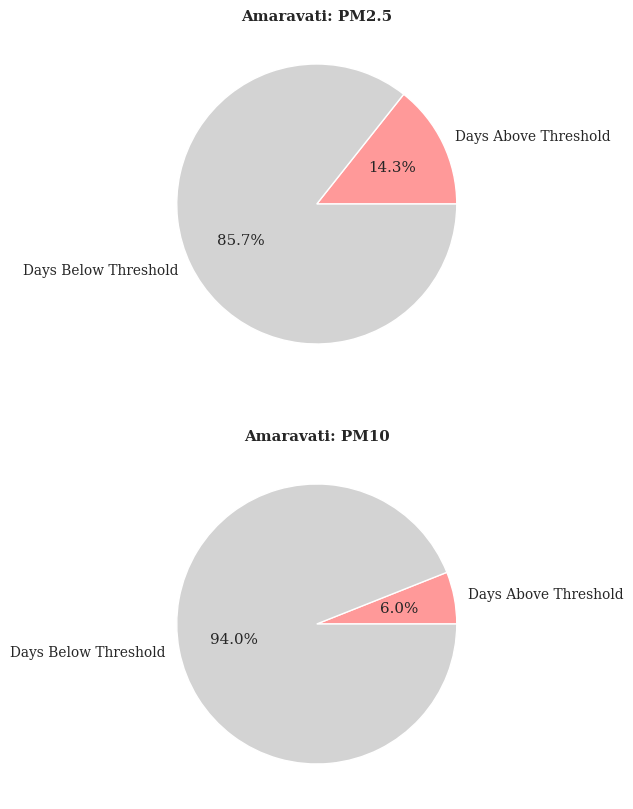

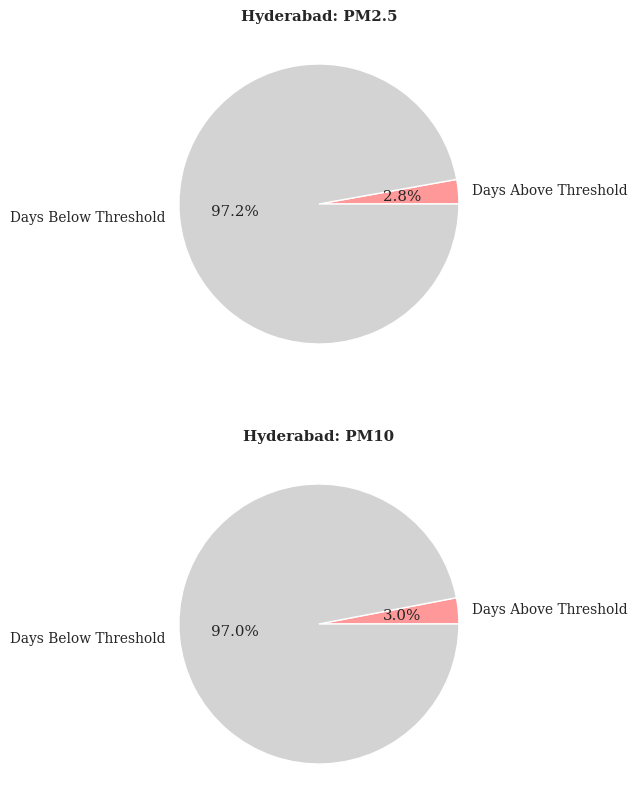

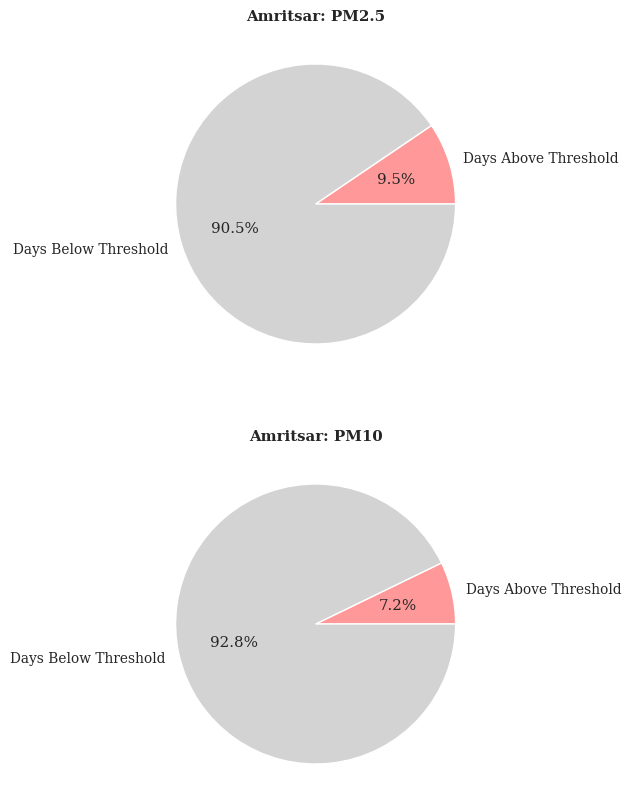

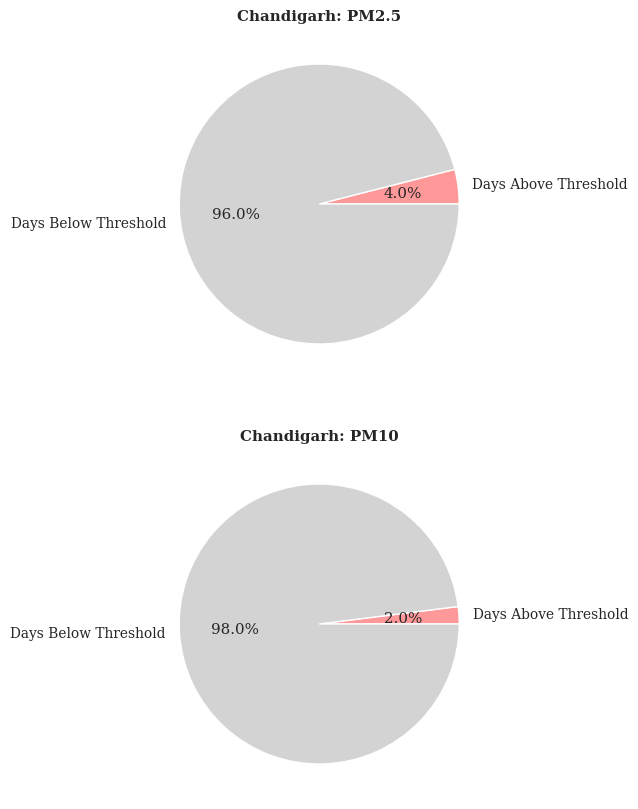

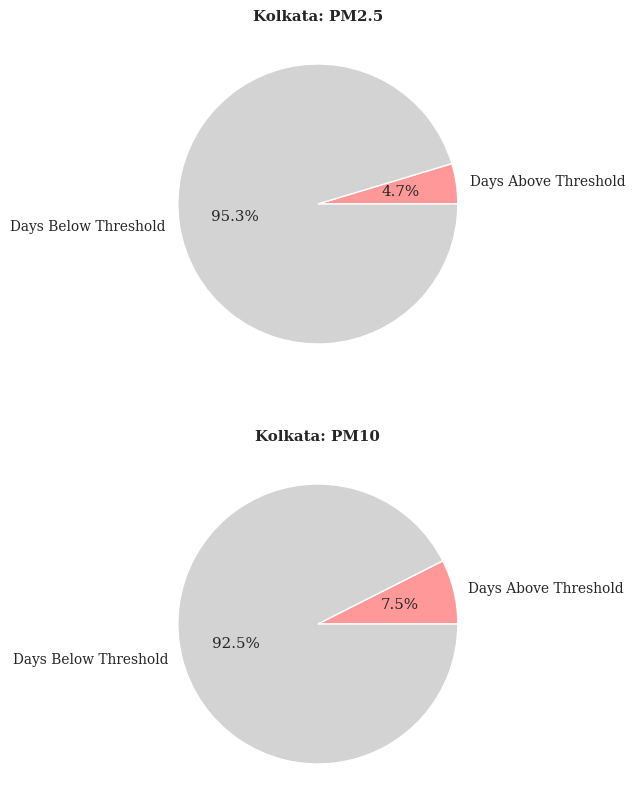

In [42]:
# Pie chart distribution by each Top Tier City showing the number of days of mean concentration of airborne PM particles above threshold limit
norm_values =  ['PM2.5', 'PM10', 'NO2', 'O3', 'CO']
norm_limits = [75, 150, 120, 160, 7]

norm_df = pd.DataFrame()

for i in range(len(norm_values)):
    norm_df[norm_values[i]] = [norm_limits[i]]

l_cities = ['Delhi', 'Visakhapatnam', 'Amaravati', 'Hyderabad', 'Amritsar', 'Chandigarh', 'Kolkata']
colors = ['#ADD8E6','#FF9999']

for i in range(len(daily_p)-1):
    city = l_cities[i]
    daily_p[i]['City'] = city
    for v in range(len(norm_values)):
        daily_p[i][f'{norm_values[v]} norm %'] = (daily_p[i][norm_values[v]] / norm_limits[v]) * 100
        daily_p[i][f'{norm_values[v]} satisfactory'] = daily_p[i][f'{norm_values[v]} norm %'] <= 100

# Pieplots showing percentages of  day counts where mean values of PM10 and PM2.5 particles exceeded WHO regulations

for i in range(len(daily_p)-1):
    labels = ['Above Threshold', 'Below Threshold']

    colors = ['grey','lightgrey']
    values_l = []

    for v in range(2):
        input = daily_p[i].groupby(f'{norm_values[v]} satisfactory').size().to_frame().reset_index()

        labels = ['Days Above Threshold', 'Days Below Threshold']

        colors = ['#FF9999','lightgrey']

        values = input[0].to_list()
        values_l.append(values)

    fig, [ax1,ax2] = plt.subplots(2,1, figsize=(10, 10))
    ax1.pie(values_l[0], labels=labels, autopct='%1.1f%%', colors=colors)
    ax1.set_title(f'{l_cities[i]}: {norm_values[0]}', weight='bold')

    ax2.pie(values_l[1], labels=labels, autopct='%1.1f%%', colors=colors)
    ax2.set_title(f'{l_cities[i]}: {norm_values[1]}', weight='bold')
    plt.show()